In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install catboost
!pip install optuna

     |████████████████████████████████| 76.3 MB 110 kB/s 
     |████████████████████████████████| 308 kB 4.3 MB/s 
     |████████████████████████████████| 209 kB 44.2 MB/s 
     |████████████████████████████████| 80 kB 10.7 MB/s 
     |████████████████████████████████| 75 kB 4.9 MB/s 
     |████████████████████████████████| 112 kB 78.2 MB/s 
     |████████████████████████████████| 149 kB 45.7 MB/s 
     |████████████████████████████████| 49 kB 6.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=69bf4c473dcd89ca4d990f8b363a1fccf50cb3f537592e601a8fb073f3cfe458
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import optuna
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold


plt.rcParams['font.family'] ='Malgun Gothic'

plt.rcParams['axes.unicode_minus'] =False
plt.rc('font', family='NanumBarunGothic') 
# plt.rcParams['font.family'] = 'NanumBarunGothic'
# %config inlinebackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 100

pd.set_option('display.max_row', 526)
pd.set_option('display.max_columns', 100)
import warnings

warnings.filterwarnings(action='ignore') 

In [4]:
path = '/content/drive/MyDrive/delivery/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
submission = pd.read_csv(path + 'sample_submission.csv')

In [5]:
train['SEND_SPG_INNB'] = train['SEND_SPG_INNB'].apply(lambda x: int(str(x)[:5]))
train['REC_SPG_INNB'] = train['REC_SPG_INNB'].apply(lambda x: int(str(x)[:5]))

test['SEND_SPG_INNB'] = test['SEND_SPG_INNB'].apply(lambda x: int(str(x)[:5]))
test['REC_SPG_INNB'] = test['REC_SPG_INNB'].apply(lambda x: int(str(x)[:5]))

In [6]:
train['delivery_identity'] = [str(i) + str(j) for i,j in zip(train['SEND_SPG_INNB'],train['REC_SPG_INNB'])]
test['delivery_identity'] = [str(i) + str(j) for i,j in zip(test['SEND_SPG_INNB'],test['REC_SPG_INNB'])]

train['product_identity'] = [str(i) + str(j) for i,j in zip(train['DL_GD_LCLS_NM'],train['DL_GD_MCLS_NM'])]
test['product_identity'] = [str(i) + str(j) for i,j in zip(test['DL_GD_LCLS_NM'],test['DL_GD_MCLS_NM'])]

In [7]:
train.drop(columns=['index'], inplace=True)
test.drop(columns=['index'], inplace=True)

In [8]:
product_identity_label = {'패션의류상의' : 0, '생활/건강반려동물' : 1, '패션의류기타패션의류' : 2, '식품농산물' : 3, '식품가공식품' : 4,
       '화장품/미용스킨케어' : 5, '식품기타식품' : 6, '생활/건강생활용품' : 7, '식품건강식품' : 8, '생활/건강주방용품' : 9,
       '생활/건강건강용품' : 10, '식품냉동/간편조리식품' : 11, '생활/건강문구/사무용품' : 12, '식품축산' : 13, '여행/문화문화컨텐츠' : 14,
       '생활/건강음반' : 15, '식품음료' : 16, '식품수산' : 17, '식품과자' : 18, '디지털/가전기타디지털/가전' : 19}

In [9]:
train['product_identity'] = train['product_identity'].apply(lambda x : product_identity_label[x])
test['product_identity'] = test['product_identity'].apply(lambda x : product_identity_label[x])

In [10]:
for i in range(0,20):
    globals()['train_{}'.format(i)] = train[train['product_identity'] == i]
    locals()['train_{}'.format(i)].reset_index(inplace=True, drop=True)

In [11]:
def outlier_iqr(data, column, cut_value): 

    # lower, upper 글로벌 변수 선언하기     
    global lower, upper    
    
    # 4분위수 기준 지정하기     
    q25, q75 = np.quantile(data[column], 0.25), np.quantile(data[column], 0.75)          
    
    # IQR 계산하기     
    iqr = q75 - q25    
    
    # outlier cutoff 계산하기     
    cut_off = iqr * cut_value
    
    # lower와 upper bound 값 구하기     
    lower, upper = q25 - cut_off, q75 + cut_off     
    
    print('IQR은',iqr, '이다.')     
    print('lower bound 값은', lower, '이다.')     
    print('upper bound 값은', upper, '이다.')    
    
    # 1사 분위와 4사 분위에 속해있는 데이터 각각 저장하기     
    data1 = data[data[column] > upper]     
    data2 = data[data[column] < lower]

    # 이상치 총 개수 구하기
    return print('총 이상치 개수는', data1.shape[0] + data2.shape[0], '이다.')

In [12]:
# outlier_idx = set()
# cut_value_value = 1.5
# for i in range(0,20):
#     print(f'product {i}')
#     outlier_iqr(locals()['train_{}'.format(i)],'INVC_CONT', cut_value_value)

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


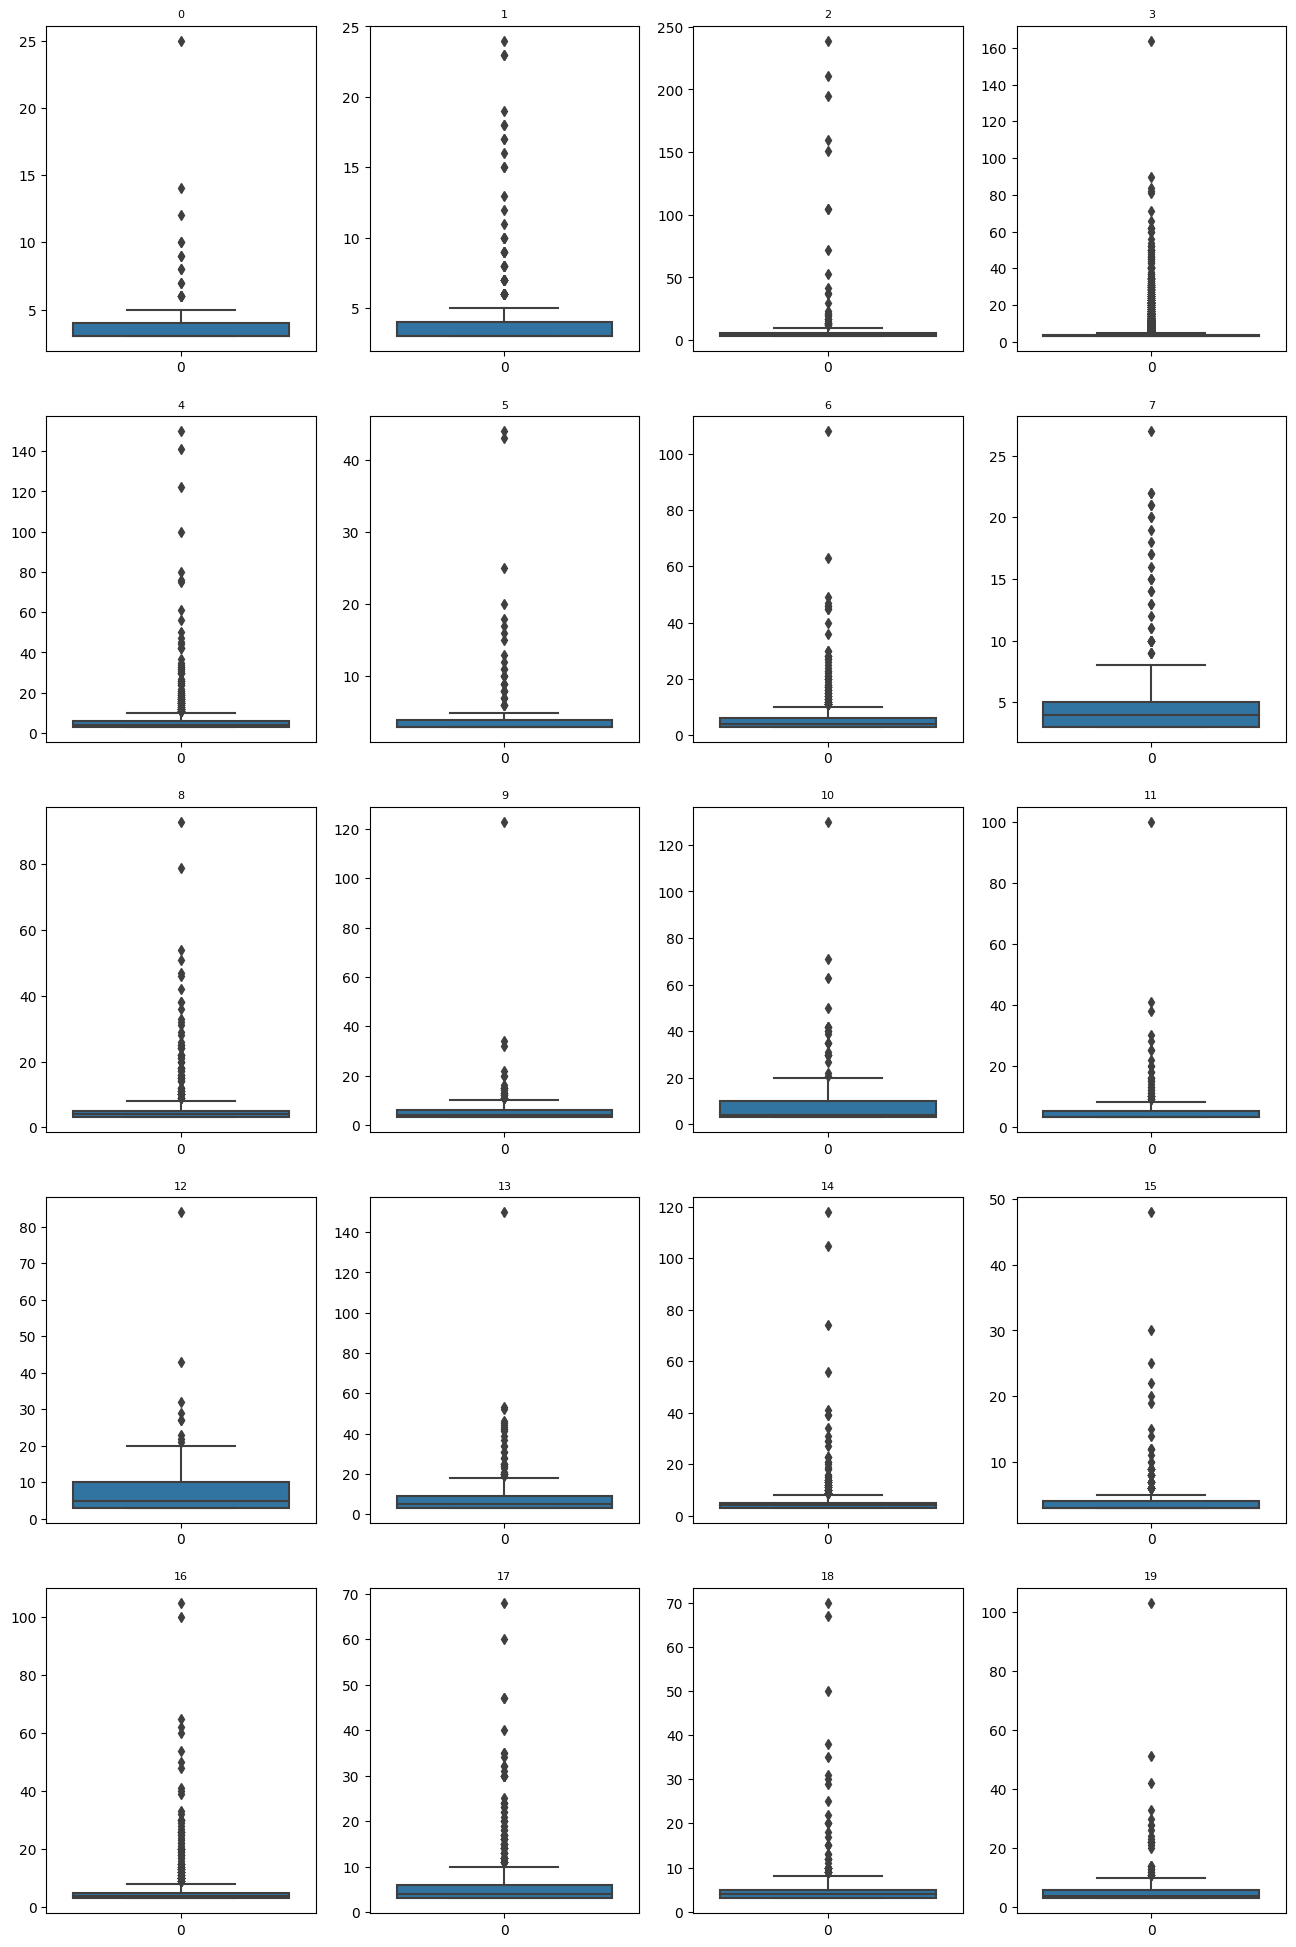

In [13]:
plt.figure(figsize=(16,25))
count = 1
for i in range(0,20):
    plt.subplot(5,4,count)
    p = sns.boxplot(data=locals()['train_{}'.format(i)]['INVC_CONT'])
    p.set_title(i, fontsize=8)
    count+=1
plt.show()

In [14]:
outlier_idx = set()

In [15]:
for i in train.INVC_CONT[train.INVC_CONT < 0].index.values:
    outlier_idx.add(i)

for i in train[train.product_identity == 0].INVC_CONT[train[train.product_identity == 0].INVC_CONT >= 15].index.values:
    outlier_idx.add(i)
for i in train[train.product_identity == 1].INVC_CONT[train[train.product_identity == 1].INVC_CONT >= 20].index.values:
    outlier_idx.add(i)
for i in train[train.product_identity == 2].INVC_CONT[train[train.product_identity == 2].INVC_CONT >= 200].index.values:
    outlier_idx.add(i)
for i in train[train.product_identity == 3].INVC_CONT[train[train.product_identity == 3].INVC_CONT >= 100].index.values:
    outlier_idx.add(i)
for i in train[train.product_identity == 4].INVC_CONT[train[train.product_identity == 4].INVC_CONT >= 120].index.values:
    outlier_idx.add(i)
for i in train[train.product_identity == 5].INVC_CONT[train[train.product_identity == 5].INVC_CONT >= 30].index.values:
    outlier_idx.add(i)
for i in train[train.product_identity == 6].INVC_CONT[train[train.product_identity == 6].INVC_CONT >= 80].index.values:
    outlier_idx.add(i)
for i in train[train.product_identity == 7].INVC_CONT[train[train.product_identity == 7].INVC_CONT >= 25].index.values:
    outlier_idx.add(i)
for i in train[train.product_identity == 8].INVC_CONT[train[train.product_identity == 8].INVC_CONT >= 60].index.values:
    outlier_idx.add(i)
for i in train[train.product_identity == 9].INVC_CONT[train[train.product_identity == 9].INVC_CONT >= 100].index.values:
    outlier_idx.add(i)
for i in train[train.product_identity == 10].INVC_CONT[train[train.product_identity == 10].INVC_CONT >= 120].index.values:
    outlier_idx.add(i)
for i in train[train.product_identity == 11].INVC_CONT[train[train.product_identity == 11].INVC_CONT >= 80].index.values:
    outlier_idx.add(i)
for i in train[train.product_identity == 12].INVC_CONT[train[train.product_identity == 12].INVC_CONT >= 70].index.values:
    outlier_idx.add(i)
for i in train[train.product_identity == 13].INVC_CONT[train[train.product_identity == 13].INVC_CONT >= 120].index.values:
    outlier_idx.add(i)
for i in train[train.product_identity == 14].INVC_CONT[train[train.product_identity == 14].INVC_CONT >= 100].index.values:
    outlier_idx.add(i)
for i in train[train.product_identity == 15].INVC_CONT[train[train.product_identity == 15].INVC_CONT >= 40].index.values:
    outlier_idx.add(i)
for i in train[train.product_identity == 16].INVC_CONT[train[train.product_identity == 16].INVC_CONT >= 80].index.values:
    outlier_idx.add(i)
for i in train[train.product_identity == 17].INVC_CONT[train[train.product_identity == 17].INVC_CONT >= 50].index.values:
    outlier_idx.add(i)
for i in train[train.product_identity == 18].INVC_CONT[train[train.product_identity == 18].INVC_CONT >= 60].index.values:
    outlier_idx.add(i)
for i in train[train.product_identity == 19].INVC_CONT[train[train.product_identity == 19].INVC_CONT >= 80].index.values:
    outlier_idx.add(i)

In [16]:
train.drop(outlier_idx, axis=0, inplace=True)

In [17]:
train = train.reset_index(drop=True)

In [18]:
train.drop(columns=['delivery_identity', 'product_identity'], inplace=True)
test.drop(columns=['delivery_identity', 'product_identity'], inplace=True)

In [19]:
data = pd.concat([train, test])

In [20]:
data['SEND_SPG_INNB'] = data['SEND_SPG_INNB'].astype('category').cat.codes
data['REC_SPG_INNB'] = data['REC_SPG_INNB'].astype('category').cat.codes

data['SEND_SPG_INNB'] = data['SEND_SPG_INNB'].astype('str')
data['REC_SPG_INNB'] = data['REC_SPG_INNB'].astype('str')

In [21]:
data = pd.get_dummies(data)

In [22]:
train, test = data.iloc[:-len(test)], data.iloc[-len(test):]

In [23]:
test.drop(columns=['INVC_CONT'], inplace=True)

In [24]:
X = train.drop(columns=['INVC_CONT'])
y = train[['INVC_CONT']]

In [25]:
def objective_cat(trial):
    """
    Objective function to tune a `CatBoostRegressor` model.
    """

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    params = {
        'iterations':trial.suggest_int("iterations", 4000, 25000),
        'od_wait':trial.suggest_int('od_wait', 500, 2300),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
        'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
        'subsample': trial.suggest_uniform('subsample',0,1),
        'random_strength': trial.suggest_uniform('random_strength',10,50),
        'depth': trial.suggest_int('depth',1, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'verbose' : False
    }


    model = CatBoostRegressor(
        loss_function="RMSE",
        random_state=42,
        **params,
    )
    model.fit(x_train, y_train)

    pred = model.predict(x_test)

    rmse = mean_squared_error(y_test, pred, squared=False)


    return rmse

In [26]:
study_catboost = optuna.create_study(direction="minimize")
study_catboost.optimize(objective_cat, n_trials=6)

[I 2021-12-12 12:41:02,931] A new study created in memory with name: no-name-b04b6416-6fbc-497e-bb31-248e4840a321
[I 2021-12-12 14:34:52,171] Trial 0 finished with value: 4.858895004837662 and parameters: {'iterations': 24534, 'od_wait': 1533, 'learning_rate': 0.19267240467789834, 'reg_lambda': 83.29415728401209, 'subsample': 0.6048345418503124, 'random_strength': 48.525258893993744, 'depth': 14, 'min_data_in_leaf': 2, 'leaf_estimation_iterations': 13}. Best is trial 0 with value: 4.858895004837662.
[I 2021-12-12 14:36:39,140] Trial 1 finished with value: 4.834871499220405 and parameters: {'iterations': 15622, 'od_wait': 1694, 'learning_rate': 0.10407973686540398, 'reg_lambda': 11.457082829520418, 'subsample': 0.5145279879926488, 'random_strength': 28.550137117387003, 'depth': 8, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 11}. Best is trial 1 with value: 4.834871499220405.
[I 2021-12-12 14:37:12,271] Trial 2 finished with value: 4.878885191675219 and parameters: {'iterations

In [27]:
params=study_catboost.best_params 
params['loss_function'] = 'RMSE'
params['random_state'] = 42 

In [28]:
preds = np.zeros(test.shape[0])
kf = KFold(n_splits=5,random_state=42,shuffle=True)
rmse=[]  # list contains mae for each fold
n=0
for trn_idx, test_idx in kf.split(train[train.columns[1:].to_list()],train['INVC_CONT']):
    X_tr,X_val=train[train.columns[1:].to_list()].iloc[trn_idx],train[train.columns[1:].to_list()].iloc[test_idx]
    y_tr,y_val=train['INVC_CONT'].iloc[trn_idx],train['INVC_CONT'].iloc[test_idx]
    model = CatBoostRegressor(**params)
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False)
    preds+=model.predict(test[train.columns[1:].to_list()])/kf.n_splits
    rmse.append(mean_squared_error(y_val, model.predict(X_val), squared=False))
    print(n+1,rmse[n])
    n+=1

1 4.626350113570817
2 4.160525725806855
3 4.571213586208013
4 4.390694432062171
5 4.538291522939929


In [29]:
submission['INVC_CONT'] = preds

In [30]:
submission.to_csv(path + 'catboost_kfold5_remove_outlier.csv', index=False)